[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/H-E-L-P/dmu_products/blob/master/dmu31/dmu31_Examples/dmu31_XID%2B_new_source_prior.ipynb)

# How to run XID+ on SPIRE maps for a new source not included in HELP 
This notebooks will guide you on how to run XID+ in a specific region to obtain the FIR flux on SPIRE maps for a new source not included in the HELP catalogue.


# 0. Install XID+

You need to have XID+ installed. Refer to [this link](http://herschel.sussex.ac.uk/XID_plus/build/html/intro.html) for more information.


In [2]:
!git clone https://github.com/H-E-L-P/XID_plus.git

In [3]:
cd XID_plus

In [5]:
!conda config --add channels conda-forge && conda install healpy

In [7]:
!while read requirement; do conda install --yes $requirement; done < req.txt

In [8]:
!pip install -r req.txt

In [9]:
!pip install -e './'


In [10]:
import sys
sys.path.append("/content/drive/work/XID_plus")

## 1. Import modules


In [1]:
import pylab as plt
%matplotlib inline
from astropy.table import Table, join

import pymoc
import numpy as np
import pickle

import xidplus
from xidplus import moc_routines, catalogue
from xidplus import posterior_maps as postmaps

# Version 4.2 of Astropy
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy import wcs

import pyvo as vo

## 2. New source

In order to obtain the FIR data for a new source, you need to run XID+ including information on the sources around it, as XID+ provides the full posterior distribution on fluxes, taking into account how every source contributes to the flux in the map. 

### 2.1 In case you don't know which sources are or are not in HELP

In case you don't have yet a catalogue with new sources, you can check whether the source is in HELP or not using [TOPCAT](http://www.star.bris.ac.uk/~mbt/topcat/) or [STILTS](http://www.star.bris.ac.uk/~mbt/stilts/) to crossmatch your catalogue with the one in HELP.

In order to obtain the HELP catalogue you can do a query using the Virtual Observatory at Sussex (check step 3 for more information on this). 

Next line of code would merge both catalogues and find sources that are in *cat2* (HELP catalogue) but not *cat1* (New catalogue) within a 1 arcsecond radius search.  


```
stilts tmatch2 in1=cat1 in2=cat2 join=2not1 find=all matcher=sky params='1' values1='ra dec' values2='ra dec' out=table.dat
```

*cat1 == HELP catalogue*

*cat2 == New catalogue*

*params == search radius*




### 2.2 Load new source coordinates



In [2]:
# Read in new source coordinates from a file
newsource = Table.read('table.dat', format='ascii') # RA, DEC in deg
newsource

Name,ra,dec
str2,float64,float64
s1,243.163,54.477


## 3. Search sources within a given radius

To select the sources near your new source coordinates, you can do an easy query from the [VO at Sussex](https://herschel-vos.phys.sussex.ac.uk/). 
If you want to learn more on how to query from the VO, you can check these example notebooks: [HELP_VO_Introduction](https://github.com/H-E-L-P/dmu_products/blob/master/dmu31/dmu31_Examples/HELP_VO_Introduction.ipynb), [Coneseach_and_Image_Cutout](https://github.com/H-E-L-P/dmu_products/blob/master/dmu31/dmu31_Examples/dmu31_coneseach_and_cutout.ipynb), [pyvo_example](https://github.com/H-E-L-P/dmu_products/blob/master/dmu31/dmu31_Examples/dmu31_pyvo_example.ipynb)

We search for sources within a given radius, center on the new source coordinates. To do that, we are using the simple cone search (SCS) to access the main catalogue. We will need to use **scs.xml** section in the VO.

[More info for catalogue queries](https://herschel-vos.phys.sussex.ac.uk/herschelhelp/q/cone/info)

In [3]:
# URL to access the VO at Sussex (VOX)
BASE_URL = "https://herschel-vos.phys.sussex.ac.uk"

# Using scs.xml section
cone_search = vo.dal.SCSService(f"{BASE_URL}/herschelhelp/q/cone/scs.xml")


We need to define the position and radius of the cone search, based in our new source coordinates. In this case we required sources within 1 arcmin radius from our new source: 

In [40]:
pos = SkyCoord(newsource['ra'][0] * u.deg, newsource['dec'][0] * u.deg)
size = 1 * u.arcmin

sources = cone_search.search(pos=pos, radius=size)
sources = sources.to_table()

sources[:5]

field,help_id,ra,dec,ebv,redshift,zspec,zspec_qual,zspec_association_flag,stellarity,stellarity_origin,f_90prime_g,ferr_90prime_g,f_ap_90prime_g,ferr_ap_90prime_g,m_90prime_g,merr_90prime_g,m_ap_90prime_g,merr_ap_90prime_g,flag_90prime_g,f_90prime_r,ferr_90prime_r,f_ap_90prime_r,ferr_ap_90prime_r,m_90prime_r,merr_90prime_r,m_ap_90prime_r,merr_ap_90prime_r,flag_90prime_r,f_90prime_z,ferr_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,m_90prime_z,merr_90prime_z,m_ap_90prime_z,merr_ap_90prime_z,flag_90prime_z,f_acs_f435w,ferr_acs_f435w,f_ap_acs_f435w,ferr_ap_acs_f435w,m_acs_f435w,merr_acs_f435w,m_ap_acs_f435w,merr_ap_acs_f435w,flag_acs_f435w,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f606w,ferr_ap_acs_f606w,m_acs_f606w,merr_acs_f606w,m_ap_acs_f606w,merr_ap_acs_f606w,flag_acs_f606w,f_acs_f775w,ferr_acs_f775w,f_ap_acs_f775w,ferr_ap_acs_f775w,m_acs_f775w,merr_acs_f775w,m_ap_acs_f775w,merr_ap_acs_f775w,flag_acs_f775w,f_acs_f814w,ferr_acs_f814w,f_ap_acs_f814w,ferr_ap_acs_f814w,m_acs_f814w,merr_acs_f814w,m_ap_acs_f814w,merr_ap_acs_f814w,flag_acs_f814w,f_acs_f850lp,ferr_acs_f850lp,f_ap_acs_f850lp,ferr_ap_acs_f850lp,m_acs_f850lp,merr_acs_f850lp,m_ap_acs_f850lp,merr_ap_acs_f850lp,flag_acs_f850lp,f_bessell_b,ferr_bessell_b,f_ap_bessell_b,ferr_ap_bessell_b,m_bessell_b,merr_bessell_b,m_ap_bessell_b,merr_ap_bessell_b,flag_bessell_b,f_bessell_i,ferr_bessell_i,f_ap_bessell_i,ferr_ap_bessell_i,m_bessell_i,merr_bessell_i,m_ap_bessell_i,merr_ap_bessell_i,flag_bessell_i,f_bessell_r,ferr_bessell_r,f_ap_bessell_r,ferr_ap_bessell_r,m_bessell_r,merr_bessell_r,m_ap_bessell_r,merr_ap_bessell_r,flag_bessell_r,f_bessell_u,ferr_bessell_u,f_ap_bessell_u,ferr_ap_bessell_u,m_bessell_u,merr_bessell_u,m_ap_bessell_u,merr_ap_bessell_u,flag_bessell_u,f_bessell_v,ferr_bessell_v,f_ap_bessell_v,ferr_ap_bessell_v,m_bessell_v,merr_bessell_v,m_ap_bessell_v,merr_ap_bessell_v,flag_bessell_v,f_cfht12k_b,ferr_cfht12k_b,f_ap_cfht12k_b,ferr_ap_cfht12k_b,m_cfht12k_b,merr_cfht12k_b,m_ap_cfht12k_b,merr_ap_cfht12k_b,flag_cfht12k_b,f_cfht12k_i,ferr_cfht12k_i,f_ap_cfht12k_i,ferr_ap_cfht12k_i,m_cfht12k_i,merr_cfht12k_i,m_ap_cfht12k_i,merr_ap_cfht12k_i,flag_cfht12k_i,f_cfht12k_r,ferr_cfht12k_r,f_ap_cfht12k_r,ferr_ap_cfht12k_r,m_cfht12k_r,merr_cfht12k_r,m_ap_cfht12k_r,merr_ap_cfht12k_r,flag_cfht12k_r,f_decam_g,ferr_decam_g,f_ap_decam_g,ferr_ap_decam_g,m_decam_g,merr_decam_g,m_ap_decam_g,merr_ap_decam_g,flag_decam_g,f_decam_i,ferr_decam_i,f_ap_decam_i,ferr_ap_decam_i,m_decam_i,merr_decam_i,m_ap_decam_i,merr_ap_decam_i,flag_decam_i,f_decam_r,ferr_decam_r,f_ap_decam_r,ferr_ap_decam_r,m_decam_r,merr_decam_r,m_ap_decam_r,merr_ap_decam_r,flag_decam_r,f_decam_y,ferr_decam_y,f_ap_decam_y,ferr_ap_decam_y,m_decam_y,merr_decam_y,m_ap_decam_y,merr_ap_decam_y,flag_decam_y,f_decam_z,ferr_decam_z,f_ap_decam_z,ferr_ap_decam_z,m_decam_z,merr_decam_z,m_ap_decam_z,merr_ap_decam_z,flag_decam_z,f_galex_fuv,ferr_galex_fuv,f_ap_galex_fuv,ferr_ap_galex_fuv,m_galex_fuv,merr_galex_fuv,m_ap_galex_fuv,merr_ap_galex_fuv,flag_galex_fuv,f_galex_nuv,ferr_galex_nuv,f_ap_galex_nuv,ferr_ap_galex_nuv,m_galex_nuv,merr_galex_nuv,m_ap_galex_nuv,merr_ap_galex_nuv,flag_galex_nuv,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_hawki_k,ferr_hawki_k,f_ap_hawki_k,ferr_ap_hawki_k,m_hawki_k,merr_hawki_k,m_ap_hawki_k,merr_ap_hawki_k,flag_hawki_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_ira

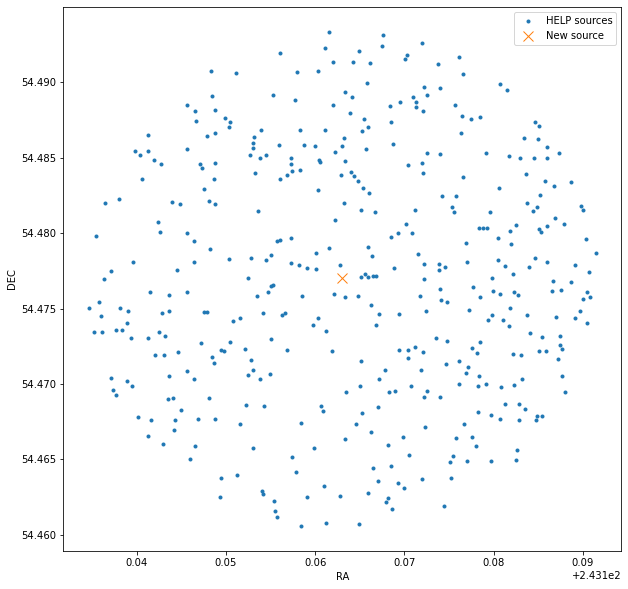

In [5]:
# Plot the sources in HELP and the new source
#############################################
plt.figure(figsize=(10,10))
plt.plot(sources['ra'], sources['dec'],'.', label='HELP sources')
plt.plot(newsource['ra'], newsource['dec'],'x', markersize=10, label='New source')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()
plt.show()

A special consideration before running XID+  is which sources to include in your prior list. You want to include sources that are contributing to the FIR source. Fitting all sources in the masterlist will produce fluxes that are degenerate; you would need to use more informative flux priors to overcome that problem.  

The column: *flag_optnir_det* includes information on how many bands your sources have been detected in. This can be use to make an inform decision on which sources to include in your prior list. 

The values assigned to each detections are: 

- 2 detections in OPTICAL bands     ---> 1
- 2 detections in NIR bands         ---> 2
- 2 detections in MIR bands (IRAC)  ---> 4

Therefore, if *flag_optnir_det* == 6 --> It means that the source has been detected in 2 NIR bands and 2 MIR bands.

In the HELP pipeline, in order to run XID+, we required a source to have *flag_optnir_det* >= 5  (in case there is IRAC detection). (HELP paper, Shirley+2021)  

In [ ]:
sources = sources[sources['flag_optnir_det'] >= 5]


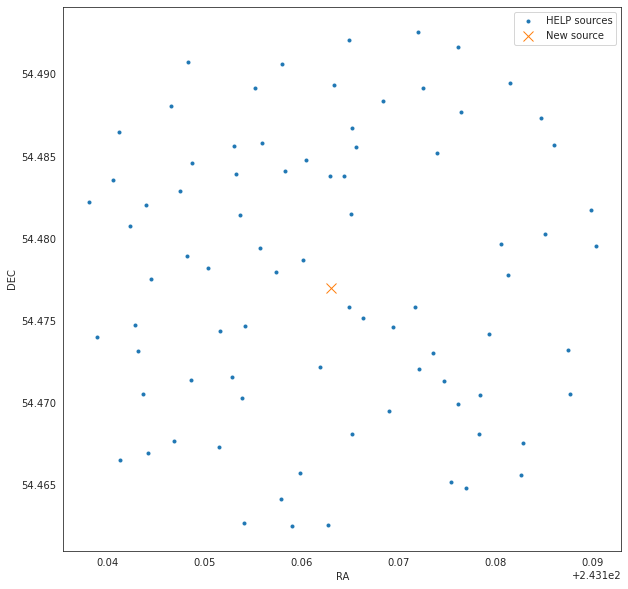

In [29]:
# Plot the sources in HELP and the new source
#############################################
plt.figure(figsize=(10,10))
plt.plot(sourcesb['ra'], sourcesb['dec'],'.', label='HELP sources')
plt.plot(newsource['ra'], newsource['dec'],'x', markersize=10, label='New source')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()
plt.show()

## 4. Add new source to query catalogue

In order to run XID+ we are only interested in the coordinates columns: *'ra', 'dec'* 

In [6]:
# Add new source to the final catalogue that we will run XID+ on
###############################################################
prior = sources[['ra','dec']].copy()
prior.add_row([newsource['ra'], newsource['dec']])

# RA, DEC coordinates to use as input for XID+
inra = prior['ra']
indec = prior['dec']

# Name of new catalogue
prior_cat = 'new_source'

## 5. Query cutouts from VO

To get cutouts from the images, we are using the simple image access protocol (SIAP). SIAP is simple for maps that overlaps (or contains, or are contained by) a region of interest defined by a position and a radius.  The cutout service has additional parameters as the `cutoutSize` that allows the server to return a link to a cropped version of the map.


[More info for cutouts queries](https://herschel-vos.phys.sussex.ac.uk/herschel_maps/q/cutout/info)

First we ask for the parameters available in the SIA query:


In [7]:
cutout_service = vo.dal.SIAService(f"{BASE_URL}/herschel_maps/q/cutout/siap.xml")
cutout_service.params

[<PARAM ID="INPUT_POS" arraysize="*" datatype="char" name="INPUT:POS" ucd="pos.eq" unit="deg" value=""/>,
 <PARAM ID="INPUT_SIZE" arraysize="*" datatype="char" name="INPUT:SIZE" unit="deg" value=""/>,
 <PARAM ID="INPUT_INTERSECT" arraysize="*" datatype="char" name="INPUT:INTERSECT" value="OVERLAPS"/>,
 <PARAM ID="INPUT_FORMAT" arraysize="*" datatype="char" name="INPUT:FORMAT" value="GRAPHIC"/>,
 <PARAM ID="INPUT_bandpassId" arraysize="*" datatype="char" name="INPUT:bandpassId" ucd="VOX:BandPass_ID" value=""/>,
 <PARAM ID="INPUT_type" arraysize="*" datatype="char" name="INPUT:type" ucd="meta.code" value=""/>,
 <PARAM ID="INPUT_cutoutSize" datatype="float" name="INPUT:cutoutSize" unit="deg" value="0.1"/>,
 <PARAM ID="INPUT_RESPONSEFORMAT" arraysize="*" datatype="char" name="INPUT:RESPONSEFORMAT" ucd="meta.code.mime" value=""/>,
 <PARAM ID="INPUT_MAXREC" datatype="int" name="INPUT:MAXREC" value="0"/>,
 <PARAM ID="INPUT_VERB" datatype="int" name="INPUT:VERB" value="0"/>]

- `type` is the kind of image we want: `image`, `error`, or `exposure`.
- `bandpassId` is the band: `SPIRE250`, `SPIRE350`, or `SPIRE500`.
- `cutoutSize` is in degrees (the value, not the astropy.unit)

Note: the `size` param (with an astropy unit because it's as standard SIA parameter) is the size used to look up for the maps overlapping the reghion of interest (by default, you can ask that the image covers the RoI, the RoI covers the image, or that the position is in the image). The `cutoutSize` is the **width** of the cutout that is returned, that may be different from the search size.

In [8]:
images = cutout_service.search(
    pos=pos, 
    size=size, 
    cutoutSize=2*size.to(u.deg).value, 
    type=['image', 'error']
)

We convert the output to astropy Table. 

Each row of the table contains all the information of the images and error maps that we have requested.

In [9]:
images = images.to_table()

In [10]:
images

accref,mime,accsize,centerAlpha,centerDelta,imageTitle,instId,dateObs,nAxes,pixelSize,pixelScale,refFrame,wcs_equinox,wcs_projection,wcs_refPixel,wcs_refValues,wcs_cdmatrix,bandpassId,bandpassUnit,bandpassRefval,bandpassHi,bandpassLo,pixflags,coverage,field,type
,,byte,deg,deg,,,d,,pix,deg / pix,,yr,,pix,deg,deg / pix,,,m,m,m,,deg,,
object,object,int32,float64,float64,object,object,float64,int32,object,object,object,float32,str3,object,object,object,object,object,float64,float64,float64,object,object,object,object
https://herschel-vos.phys.sussex.ac.uk/getproduct/herschel_maps/data/ELAIS-N1-NEST_error_250_SMAP_v6.0.fits?sdec=0.0333333333333&dec=54.477&ra=243.163&sra=0.0573694123127,image/fits,800,243.163,54.477,ELAIS-N1 SPIRE250 (error),SPIRE,--,2,[3169 3063],[0.00166667 0.00166667],ICRS,2000.0,TAN,[9.96050937103223 -10.038489127990488],[243.163 54.477],[-0.00166667 0.0 0.0 0.00166667],SPIRE250,m,--,--,--,,[247.23872767932954 52.441522077780526 247.82508751082247 57.52501483463201 237.99980262517744 57.52501483463201 238.5861624566709 52.441522077780526],ELAIS-N1,error
https://herschel-vos.phys.sussex.ac.uk/getproduct/herschel_maps/data/ELAIS-N1-NEST_error_350_SMAP_v6.0.fits?sdec=0.0333333333333&dec=54.477&ra=243.163&sra=0.0573694123127,image/fits,414,243.163,54.477,ELAIS-N1 SPIRE350 (error),SPIRE,--,2,[2281 2205],[0.00231481 0.00231481],ICRS,2000.0,TAN,[7.171596007196513 -7.227741661280106],[243.163 54.477],[-0.00231481 0.0 0.0 0.00231481],SPIRE350,m,--,--,--,,[247.23702610531043 52.442694103835755 247.82298163757028 57.52472656914719 238.00190849842963 57.52472656914719 238.58786403068942 52.442694103835755],ELAIS-N1,error
https://herschel-vos.phys.sussex.ac.uk/getproduct/herschel_maps/data/ELAIS-N1-NEST_error_500_SMAP_v6.0.fits?sdec=0.0333333333333&dec=54.477&ra=243.163&sra=0.0573694123127,image/fits,200,243.163,54.477,ELAIS-N1 SPIRE500 (error),SPIRE,--,2,[1585 1532],[0.00333333 0.00333333],ICRS,2000.0,TAN,[4.980269626295126 -5.019259621744027],[243.163 54.477],[-0.00333333 0.0 0.0 0.00333333],SPIRE500,m,--,--,--,,[247.2388963686566 52.44318060075605 247.82530490675651 57.52667224407192 237.99958522924337 57.52667224407192 238.58599376734387 52.44318060075605],ELAIS-N1,error
https://herschel-vos.phys.sussex.ac.uk/getproduct/herschel_maps/data/ELAIS-N1-NEST_image_250_SMAP_v6.0.fits?sdec=0.0333333333333&dec=54.477&ra=243.163&sra=0.0573694123127,image/fits,800,243.163,54.477,ELAIS-N1 SPIRE250 (image),SPIRE,--,2,[3169 3063],[0.00166667 0.00166667],ICRS,2000.0,TAN,[9.96050937103223 -10.038489127990488],[243.163 54.477],[-0.00166667 0.0 0.0 0.00166667],SPIRE250,m,--,--,--,,[247.23872767932954 52.441522077780526 247.82508751082247 57.52501483463201 237.99980262517744 57.52501483463201 238.5861624566709 52.441522077780526],ELAIS-N1,image
https://herschel-vos.phys.sussex.ac.uk/getproduct/herschel_maps/data/ELAIS-N1-NEST_image_350_SMAP_v6.0.fits?sdec=0.0333333333333&dec=54.477&ra=243.163&sra=0.0573694123127,image/fits,414,243.163,54.477,ELAIS-N1 SPIRE350 (image),SPIRE,--,2,[2281 2205],[0.00231481 0.00231481],ICRS,2000.0,TAN,[7.171596007196513 -7.227741661280106],[243.163 54.477],[-0.00231481 0.0 0.0 0.00231481],SPIRE350,m,--,--,--,,[247.23702610531043 52.442694103835755 247.82298163757028 57.52472656914719 238.00190849842963 57.52472656914719 238.58786403068942 52.442694103835755],ELAIS-N1,image
https://herschel-vos.phys.sussex.ac.uk/getproduct/herschel_maps/data/ELAIS-N1-NEST_image_500_SMAP_v6.0.fits?sdec=0.0333333333333&dec=54.477&ra=243.163&sra=0.0573694123127,image/fits,200,243.163,54.477,ELAIS-N1 SPIRE500 (image),SPIRE,--,2,[1585 1532],[0.00333333 0.00333333],ICRS,2000.0,TAN,[4.980269626295126 -5.019259621744027],[243.163 54.477],[-0.00333333 0.0 0.0 0.00333333],SPIRE500,m,--,--,--,,[247.2388963686566 52.44318060075605 247.82530490675651 57.52667224407192 237.99958522924337 57.52667224407192 238.58599376734387 52.44318060075605],ELAIS-N1,image


## 5.2 Read maps information

Next step we need to read the imformation on each image/error map that we will need as input for XID+.

We extract that information from the table above. We will focus on the columns **type** and **bandpassId**.

- **type** indicates whether it is the *image* or the *error* map. 

- **bandpassId** states the SPIRE band: *SPIRE250* , *SPIRE350*, *SPIRE500*

In [11]:
# Images data
spire250_image_map = fits.open(
    images[(images['type'] == 'image') & (images['bandpassId'] == 'SPIRE250')][0]['accref']
)

spire350_image_map = fits.open(
    images[(images['type'] == 'image') & (images['bandpassId'] == 'SPIRE350')][0]['accref']
)

spire500_image_map = fits.open(
    images[(images['type'] == 'image') & (images['bandpassId'] == 'SPIRE500')][0]['accref']
)

# Error map data
spire250_err_map = fits.open(
    images[(images['type'] == 'error') & (images['bandpassId'] == 'SPIRE250')][0]['accref']
)

spire350_err_map = fits.open(
    images[(images['type'] == 'error') & (images['bandpassId'] == 'SPIRE350')][0]['accref']
)

spire500_err_map = fits.open(
    images[(images['type'] == 'error') & (images['bandpassId'] == 'SPIRE500')][0]['accref']
)

### XID+ input data

In [12]:
#-----250-------------
im250phdu=spire250_image_map[0].header
im250hdu=spire250_image_map['IMAGE'].header

im250=spire250_image_map['IMAGE'].data*1.0E3 #convert to mJy
nim250=spire250_err_map['ERROR'].data*1.0E3 #convert to mJy

w_250 = wcs.WCS(spire250_image_map['IMAGE'].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)


#-----350-------------
im350phdu=spire350_image_map[0].header
im350hdu=spire350_image_map['IMAGE'].header

im350=spire350_image_map['IMAGE'].data*1.0E3 #convert to mJy
nim350=spire350_err_map['ERROR'].data*1.0E3 #convert to mJy

w_350 = wcs.WCS(spire350_image_map['IMAGE'].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)


#-----500-------------
im500phdu=spire500_image_map[0].header
im500hdu=spire500_image_map['IMAGE'].header

im500=spire500_image_map['IMAGE'].data*1.0E3 #convert to mJy
nim500=spire500_err_map['ERROR'].data*1.0E3 #convert to mJy

w_500 = wcs.WCS(spire500_image_map['IMAGE'].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)




## 6. Run XID+ 
For more information on XID+ you can check the Notebooks in [XID+examples](https://github.com/H-E-L-P/XID_plus/tree/master/docs/notebooks/examples)

### 6.1 Set XID+ prior class
The prior class for each map being fitted is initiated with a map, noise map, primary header and map header (which we have obtained in point 5) and can be set with a MOC. It also requires an input prior catalogue -in this case, the prior catalogue including the new source and sources around a given radius, defined in point 4.

We also need to define a point spread function (PRF). For SPIRE, the PRF can be assumed to be Gaussian with a FWHM of 18.15, 25.15, 36.3 '' for 250, 350 and 500 $\mathrm{\mu m}$ respectively.



In [31]:
# Initiate prior class
######################

#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(inra,indec,prior_cat)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu)
prior350.prior_cat(inra,indec,prior_cat)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu)
prior500.prior_cat(inra,indec,prior_cat)
prior500.prior_bkg(-5.0,5)

In [32]:
# Set PRF
######################

#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

This are the number of sources we will fit, and number of pixels on each map


In [33]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')


fitting 83 sources 

using 439, 239 and 120 pixels


Before fitting, we need to calculate the pointing matrix for each prior class. The pointing matrix takes the PRF and calculate how much each source contributes to each pixel.

Default prior on flux is a uniform distribution, with a minimum and maximum of 0.00 and 1000.0 $\mathrm{mJy}$ respectively for each source. Running the function upper_lim_map resets the upper limit to the maximum flux value (plus a 5 sigma Background value) found in the map in which the source makes a contribution to.


In [34]:
priors = [prior250, prior350, prior500]
for p in priors:
    p.get_pointing_matrix()
    p.upper_lim_map()

### 6.2 Fitting 

XID+ was run originally with stan. There is a new version available using pyro.  

In [35]:
from xidplus.stan_fit import SPIRE
fit_basic=SPIRE.all_bands(prior250,prior350,prior500,iter=1000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6cc18a5a79f36bf3802ce659b7e57421 NOW.


/XID+SPIRE not found or wrong version. Compiling


### 6.3 Set XID+ posterior class 
Initialise the posterior class with the fit object from pystan, and save the prior classes into a pkl file.

This file contain the full posterior distribution on fluxes.


In [36]:
# Save the posterior to a pkl file
posterior=xidplus.posterior_stan(fit_basic,priors)
xidplus.save(priors,posterior,'./testb')
      

### 6.4 Final catalogue and PValue maps from posterior  

We can obtain the final catalogue from the posterior. Fluxes for each galaxy is defined as the 50th percentile of the flux posterior, and the upper and lower errors are the 84th and 16th percentiles respectively.

In [37]:
# Save catalogue
cat=catalogue.create_SPIRE_cat(posterior, priors[0],priors[1],priors[2])
cat.writeto('./testb_SPIRE_cat.fits',overwrite=True)

We can also create the PValue maps. These are based on Bayesian p-values, converted to a typical '$\sigma$' level

The Bayesian p-value calculate the fraction of $y^{rep}$ samples above and below real map value. It gives usthe probability of drawing the real pixel value, from our model which has been inferred on the data.

For a more extended example on posterior analysis check out this [notebook](XID_plus/docs/notebooks/examples/XID+posterior_analysis_validation.ipynb)

In [38]:
# Create pvalue maps
post_rep_map=postmaps.replicated_maps(priors,posterior,nrep=2000)
band=['psw','pmw','plw']
for i,p in enumerate(priors):
    Bayesian_Pval=postmaps.make_Bayesian_pval_maps(priors[i],post_rep_map[i])
    wcs_temp=wcs.WCS(priors[i].imhdu)
    ra,dec=wcs_temp.wcs_pix2world(priors[i].sx_pix,priors[i].sy_pix,0)
    Bayes_map=postmaps.make_fits_image(priors[i],Bayesian_Pval)
    Bayes_map.writeto('./testb'+band[i]+'_Bayes_Pval.fits',overwrite=True)

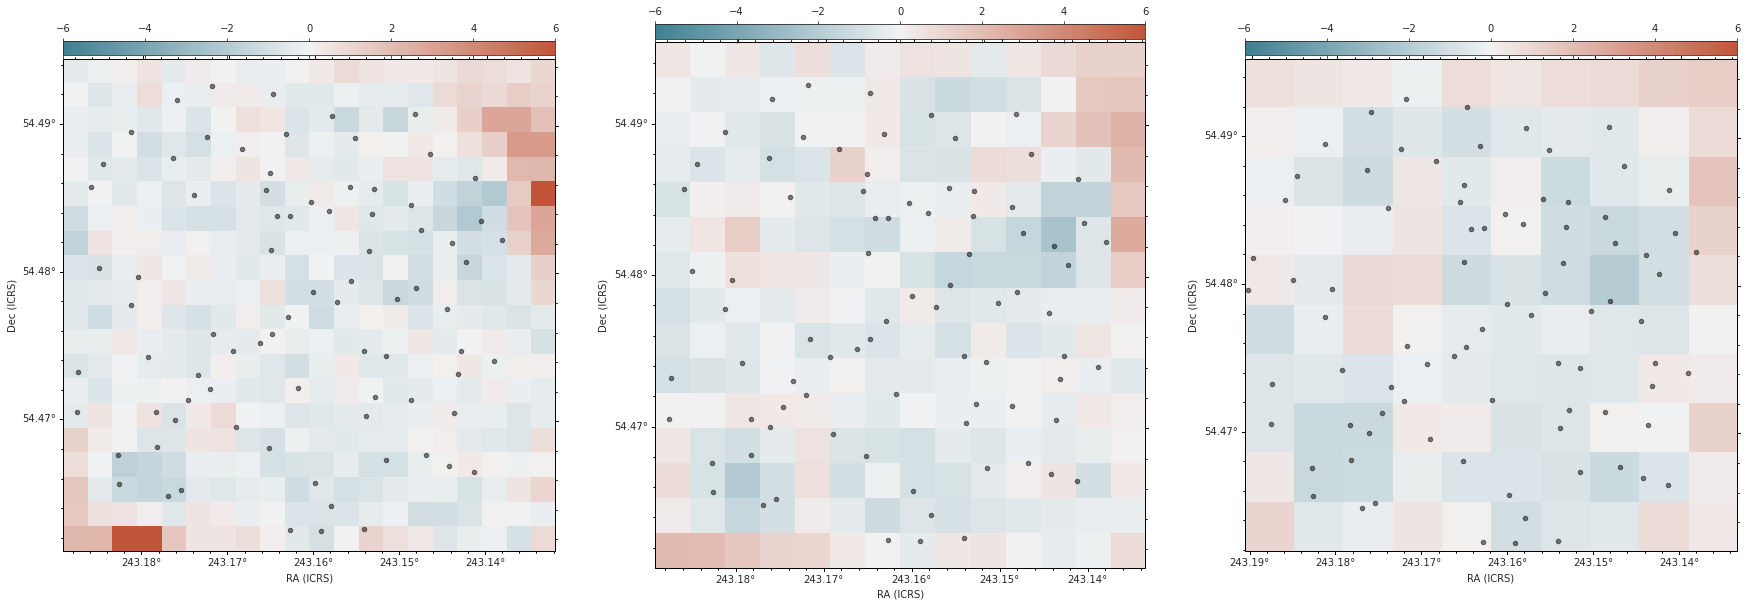

In [39]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

### Example of Pvalue maps after fitting all sources in the masterlist


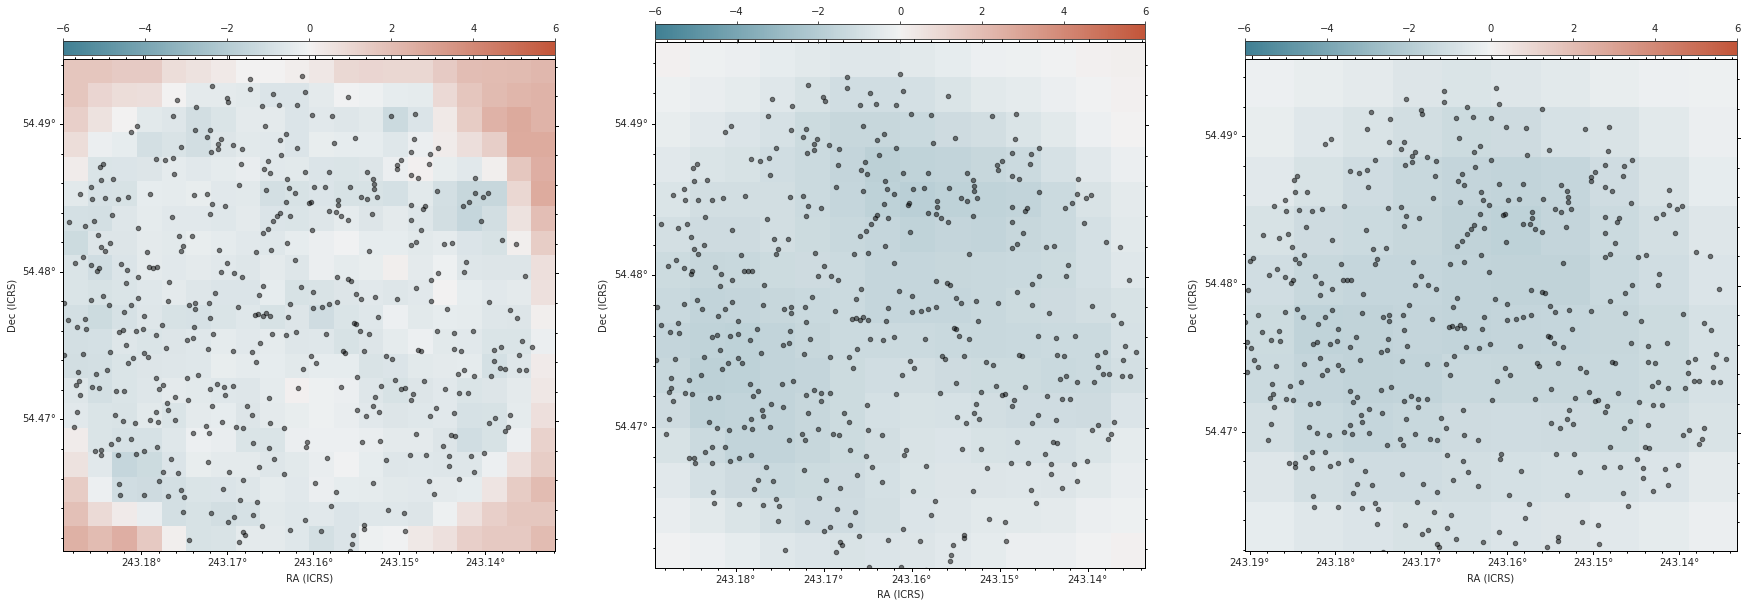

In [23]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)